In [1]:
import faiss
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn import neighbors

# add comments

# check if faiss can add extra data to index

# Data Prep

In [2]:
%%time
stuff = pd.read_csv("c2vpoint2m.txt.gz", sep="\t", header=None)

CPU times: user 22.3 s, sys: 3.06 s, total: 25.4 s
Wall time: 31.2 s


In [3]:
%%time
stuff2 = pd.read_csv("c2vpoint3m.txt.gz", sep="\t", header=None)

CPU times: user 33.3 s, sys: 7.73 s, total: 41 s
Wall time: 44.2 s


In [5]:
%%time
stuff_big = pd.read_csv("chem2vec.txt.gz", sep="\t", header=None)

KeyboardInterrupt: 

In [3]:
stuff.set_index(0, inplace=True)

In [4]:
%%time
cgan = pd.read_csv("activities.txt.gz", sep="\t")

CPU times: user 28.5 s, sys: 6.02 s, total: 34.6 s
Wall time: 37.5 s


In [5]:
egfr_activity = cgan[cgan['target'] == 'EGFR'].set_index('compound')

In [6]:
egfr_active = egfr_activity[egfr_activity['activity'] >= 6]
egfr_active_compounds = egfr_active.index.values

In [7]:
egfr_inactive = egfr_activity[egfr_activity['activity']  < 6]
egfr_inactive_compounds = egfr_inactive.index.values

In [8]:
egfr_features = pd.read_csv("egfr.c2v.txt", sep="\t", header=None).set_index(0)

In [9]:
egfr_compounds = egfr_features.index.values

In [10]:
egfr_active_features = egfr_features.loc[egfr_active_compounds]
egfr_inactive_features = egfr_features.loc[egfr_inactive_compounds]

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()

In [12]:
egfr_active_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_active_features), 
                                         index=egfr_active_features.index)

In [13]:
egfr_inactive_features_norm = pd.DataFrame(min_max_scaler.fit_transform(egfr_inactive_features), 
                                           index=egfr_inactive_features.index)

In [14]:
len(list(set(stuff.index.values) & set(egfr_compounds)))

1113

In [15]:
stuff_cleaned = stuff.loc[list(set(stuff.index.values) - set(egfr_compounds))]

In [16]:
stuff_cleaned_norm = pd.DataFrame(min_max_scaler.fit_transform(stuff_cleaned), index=stuff_cleaned.index)

In [17]:
all(i not in egfr_active_features_norm.index.values for i in stuff_cleaned_norm.index.values)

True

# Faiss Test

In [42]:
d = 64

In [43]:
nb = 100000

In [44]:
nq = 10000

In [45]:
np.random.seed(1234)

In [46]:
xb = np.random.random((nb, d)).astype('float32')

In [47]:
xb[:, 0] += np.arange(nb) / 1000.

In [26]:
xb

array([[1.91519454e-01, 6.22108757e-01, 4.37727749e-01, ...,
        6.24916732e-01, 4.78093803e-01, 1.95675179e-01],
       [3.83317441e-01, 5.38736843e-02, 4.51648414e-01, ...,
        1.51395261e-01, 3.35174650e-01, 6.57551765e-01],
       [7.53425434e-02, 5.50063960e-02, 3.23194802e-01, ...,
        3.44416976e-01, 6.40880406e-01, 1.26205325e-01],
       ...,
       [1.00811470e+02, 5.90245306e-01, 7.98893511e-01, ...,
        3.39859009e-01, 3.01949501e-01, 8.53854537e-01],
       [1.00669464e+02, 9.16068792e-01, 9.55078781e-01, ...,
        5.95364332e-01, 3.84918079e-02, 1.05637990e-01],
       [1.00855637e+02, 5.91134131e-01, 6.78907931e-01, ...,
        2.18976989e-01, 6.53015897e-02, 2.17538327e-01]], dtype=float32)

In [48]:
xq = np.random.random((nq, d)).astype('float32')

In [49]:
xq[:, 0] += np.arange(nq) / 1000.

In [29]:
index = faiss.IndexIVFFlat()

In [30]:
index = faiss.IndexFlatL2(d)

In [31]:
index = faiss.IndexFlatIP(d)

In [32]:
index = faiss.IndexHNSWFlat(d, 32)

In [30]:
index.is_trained

True

In [31]:
print(index)

<faiss.swigfaiss.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7f39f62324e0> >


In [ ]:
print(index.is_trained)

In [32]:
index.d = 64

In [ ]:
index.add(xb)

In [ ]:
print(index.ntotal)

In [ ]:
k = 4

In [ ]:
D, I = index.search(xb[:5], k)
print(I)
print(D)

In [ ]:
D, I = index.search(xq, k)     
print(I[:5])                   
print(I[-5:])                  

In [ ]:
if []:
    print("yay")

In [ ]:
arr = np.arange(9).reshape(3, 3)
arr

In [ ]:
arr2 = np.ascontiguousarray(arr, 'float32')
arr2

In [ ]:
test = egfr_active_features.sample(n=500, random_state=0)

In [ ]:
all(i in egfr_active_features.index.values for i in test.index.values)

In [66]:
d = 64

In [69]:
m = 63                            # number of subquantizers
n_bits = 8                               # bits allocated per subquantizer
pq = faiss.IndexPQ (d, m, n_bits)        # Create the index
pq.train (xb)                       # Training
pq.add (xb)                          # Populate the index
D, I = pq.search (xq, 5)            # Perform a search

RuntimeError: Error in void faiss::ProductQuantizer::set_derived_values() at ProductQuantizer.cpp:168: Error: 'd % M == 0' failed

In [214]:
import annoy

# Logic Creation

In [18]:
def knn(rest, sample_from, success, size, n_neighbors, algorithm, metric, seed):
    sizer = int(sample_from.shape[0] * size + .5)
    #print(size)
    query = sample_from.sample(n=sizer, random_state=seed)
    sub = list(set(sample_from.index.values) - set(query.index.values))
    act_without_query = sample_from.loc[sub]
    database = pd.concat([act_without_query]+rest)
    
    model = neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
    start = time.time()
    model.fit(database)
    end = time.time()
    time_to_build = end - start
    start = time.time()
    _, indices = model.kneighbors(query)
    #print(indices[:10])
    #print(distances[:10])
    end = time.time()
    time_to_query = end - start
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if database.index.values[j] in success.index.values:
                count += 1
        sum += count/float(n_neighbors)
    average = sum/query.shape[0]
    d = OrderedDict({'algorithm/index':[algorithm], 'n_neighbors':[n_neighbors], 'query size':[size], 'metric':[metric], 
                     'build time (s)':[time_to_build], 'query time (s)':[time_to_query], 'quality':[average], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

In [19]:
def dataprep(active, rest, size, seed):
    size = int(active.shape[0] * size + .5)
    query = active.sample(n=size, random_state=seed)
    sub = list(set(active.index.values) - set(query.index.values))
    active_minus_query = active.loc[sub]
    database = pd.concat([active_minus_query] + rest)#.astype('float32')
    
    return database, query

In [55]:
def buildFaissModel(database, n_neighbors, index_type, args):
    
    if args:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1], *args)
    else:
        index = getattr(faiss, 'Index' + index_type)(database.shape[1])
        
        
    if index_type == 'PQ':
        index.train(np.ascontiguousarray(database.values, 'float32'))
 
    start = time.time()
    index.add(np.ascontiguousarray(database.values, 'float32'))
    end = time.time()
    
    build_time = end - start
    
    return index, build_time


In [21]:
def runFaissQuery(model, query, k, db, success):
    
    start = time.time()
    distances, indices = model.search(np.ascontiguousarray(query.values, 'float32'), k)
    end = time.time()
    
    query_time = end - start
    sum = 0
    for i in indices:
        count = 0
        for j in i:
            if db.index.values[j] in success.index.values:
                count += 1
        sum += count / float(k)
    avg = sum / query.shape[0]
    
    return avg, query_time
    

In [85]:
def faissNN(active, rest, size, k, index_type, seed, args=[]):
    database, query = dataprep(active, rest, size, seed)
    model, build_time = buildFaissModel(database, k, index_type, args)
    avg, query_time = runFaissQuery(model, query, k, database, active)
    
    d = OrderedDict({'algorithm/index':[index_type], 'metric':[None], 'n_neighbors':[k], 
                     'query size':[size], 'build time (s)':[build_time], 'query time (s)':[query_time], 
                     'quality':[avg], 'seed':[seed]})
    
    return pd.DataFrame(data=d)
    

In [ ]:
def buildAnnoyModel(database, k, index_type, args):
    t = AnnoyIndex(database.shape[1])

In [ ]:
def runAnnoyQuery(model, query, k, database, active):
    

In [215]:
def annoyNN(active, rest, size, k, index_type, seed, args=[]):
    database, query = dataprep(active, rest, size, seed)
    model, build_time = buildAnnoyModel(database, k, index_type, args)
    avg, query_time = runQAnnoyQuery(model, query, k, database, active)
    
    d = OrderedDict({'algorithm/index':[index_type], 'metric':[None], 'n_neighbors':[k], 
                     'query size':[size], 'build time (s)':[build_time], 'query time (s)':[query_time], 
                     'quality':[avg], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

In [ ]:
def buildNSMLIBModel(database, k, index_type, args):
    

In [41]:
def NMSLIBNN(active, rest, size, k, index_type, seed, args=[]):
    database, query = dataprep(active, rest, size, seed)
    model, build_time = buildNMSLIBModel(database, k, index_type, args)
    avg, query_time = runQuery(model, query, k, database, active)
    
    d = OrderedDict({'algorithm/index':[index_type], 'metric':[None], 'n_neighbors':[k], 
                     'query size':[size], 'build time (s)':[build_time], 'query time (s)':[query_time], 
                     'quality':[avg], 'seed':[seed]})
    
    return pd.DataFrame(data=d)

# Tests

In [23]:
TABLE_RAW = pd.DataFrame()
TABLE_NORM = pd.DataFrame()

In [24]:
temp = knn([stuff_cleaned, egfr_inactive_features], egfr_active_features, egfr_active, 
               0.2, 100, 'brute', 'euclidean', 0)
TABLE_RAW = pd.concat([TABLE_RAW, temp])

In [25]:
temp = []
for metric in ['euclidean', 'cosine']:
    for seed in range(5):
        temp.append(knn([stuff_cleaned_norm, egfr_inactive_features_norm], egfr_active_features_norm, egfr_active,
                       0.2, 100, 'brute', metric, seed))
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [153]:
temporary = TABLE_NORM

In [27]:
temp = []
for algorithm in ['kd_tree', 'ball_tree']:
    for seed in range(5):
        temp.append(knn([stuff_cleaned_norm, egfr_inactive_features_norm], egfr_active_features_norm, egfr_active,
                       0.2, 100, algorithm, 'euclidean', seed))

In [28]:
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [29]:
TABLE_NORM

,algorithm/index,n_neighbors,query size,metric,build time (s),query time (s),quality,seed
0,brute,100,0.2,euclidean,0.165012,4.812468,0.998022,0
0,brute,100,0.2,euclidean,0.087079,4.793198,0.996231,1
0,brute,100,0.2,euclidean,0.088285,4.209342,0.997836,2
0,brute,100,0.2,euclidean,0.076634,4.175714,0.998507,3
0,brute,100,0.2,euclidean,0.080415,4.325893,0.998433,4
0,brute,100,0.2,cosine,0.094218,6.116019,0.998060,0
0,brute,100,0.2,cosine,0.088929,5.694500,0.996250,1
0,brute,100,0.2,cosine,0.090712,5.534836,0.997836,2
0,brute,100,0.2,cosine,0.077965,5.698534,0.999123,3
0,brute,100,0.2,cosine,0.082029,5.734892,0.999030,4


In [30]:
temp = []
for index in ['FlatL2', 'FlatIP']:
    for seed in range(5):
        temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                           0.2, 100, index, seed))
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [31]:
TABLE_NORM

,algorithm/index,build time (s),metric,n_neighbors,quality,query size,query time (s),seed
0,brute,0.165012,euclidean,100,0.998022,0.2,4.812468,0
0,brute,0.087079,euclidean,100,0.996231,0.2,4.793198,1
0,brute,0.088285,euclidean,100,0.997836,0.2,4.209342,2
0,brute,0.076634,euclidean,100,0.998507,0.2,4.175714,3
0,brute,0.080415,euclidean,100,0.998433,0.2,4.325893,4
0,brute,0.094218,cosine,100,0.998060,0.2,6.116019,0
0,brute,0.088929,cosine,100,0.996250,0.2,5.694500,1
0,brute,0.090712,cosine,100,0.997836,0.2,5.534836,2
0,brute,0.077965,cosine,100,0.999123,0.2,5.698534,3
0,brute,0.082029,cosine,100,0.999030,0.2,5.734892,4


In [32]:
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'HNSWFlat', seed, [64]))
    
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [33]:
TABLE_NORM

,algorithm/index,build time (s),metric,n_neighbors,quality,query size,query time (s),seed
0,brute,0.165012,euclidean,100,0.998022,0.2,4.812468,0
0,brute,0.087079,euclidean,100,0.996231,0.2,4.793198,1
0,brute,0.088285,euclidean,100,0.997836,0.2,4.209342,2
0,brute,0.076634,euclidean,100,0.998507,0.2,4.175714,3
0,brute,0.080415,euclidean,100,0.998433,0.2,4.325893,4
0,brute,0.094218,cosine,100,0.998060,0.2,6.116019,0
0,brute,0.088929,cosine,100,0.996250,0.2,5.694500,1
0,brute,0.090712,cosine,100,0.997836,0.2,5.534836,2
0,brute,0.077965,cosine,100,0.999123,0.2,5.698534,3
0,brute,0.082029,cosine,100,0.999030,0.2,5.734892,4


In [145]:
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'LSH', seed, [256]))
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [146]:
TABLE_NORM

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,brute,euclidean,100,0.2,0.165012,4.812468,0.998022,0
0,brute,euclidean,100,0.2,0.087079,4.793198,0.996231,1
0,brute,euclidean,100,0.2,0.088285,4.209342,0.997836,2
0,brute,euclidean,100,0.2,0.076634,4.175714,0.998507,3
0,brute,euclidean,100,0.2,0.080415,4.325893,0.998433,4
0,brute,cosine,100,0.2,0.094218,6.116019,0.998060,0
0,brute,cosine,100,0.2,0.088929,5.694500,0.996250,1
0,brute,cosine,100,0.2,0.090712,5.534836,0.997836,2
0,brute,cosine,100,0.2,0.077965,5.698534,0.999123,3
0,brute,cosine,100,0.2,0.082029,5.734892,0.999030,4


In [37]:
TABLE_NORM = TABLE_NORM[["algorithm/index", "metric", "n_neighbors", "query size", 
                        "build time (s)", "query time (s)", "quality", "seed"]]

In [38]:
TABLE_NORM

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,brute,euclidean,100,0.2,0.165012,4.812468,0.998022,0
0,brute,euclidean,100,0.2,0.087079,4.793198,0.996231,1
0,brute,euclidean,100,0.2,0.088285,4.209342,0.997836,2
0,brute,euclidean,100,0.2,0.076634,4.175714,0.998507,3
0,brute,euclidean,100,0.2,0.080415,4.325893,0.998433,4
0,brute,cosine,100,0.2,0.094218,6.116019,0.998060,0
0,brute,cosine,100,0.2,0.088929,5.694500,0.996250,1
0,brute,cosine,100,0.2,0.090712,5.534836,0.997836,2
0,brute,cosine,100,0.2,0.077965,5.698534,0.999123,3
0,brute,cosine,100,0.2,0.082029,5.734892,0.999030,4


In [154]:
TABLE_NORM.to_csv(path_or_buf='tablenorm.txt')

In [80]:
temp = []
for seed in range(5):
    temp.append(faissNN(egfr_active_features_norm, [stuff_cleaned_norm, egfr_inactive_features_norm],
                       0.2, 100, 'PQ', seed, [1, 8]))
TABLE_NORM = pd.concat([TABLE_NORM] + temp)

In [155]:
TABLE_NORM

,algorithm/index,metric,n_neighbors,query size,build time (s),query time (s),quality,seed
0,brute,euclidean,100,0.2,0.165012,4.812468,0.998022,0
0,brute,euclidean,100,0.2,0.087079,4.793198,0.996231,1
0,brute,euclidean,100,0.2,0.088285,4.209342,0.997836,2
0,brute,euclidean,100,0.2,0.076634,4.175714,0.998507,3
0,brute,euclidean,100,0.2,0.080415,4.325893,0.998433,4
0,brute,cosine,100,0.2,0.094218,6.116019,0.998060,0
0,brute,cosine,100,0.2,0.088929,5.694500,0.996250,1
0,brute,cosine,100,0.2,0.090712,5.534836,0.997836,2
0,brute,cosine,100,0.2,0.077965,5.698534,0.999123,3
0,brute,cosine,100,0.2,0.082029,5.734892,0.999030,4


In [157]:
a = TABLE_NORM

# Graphs

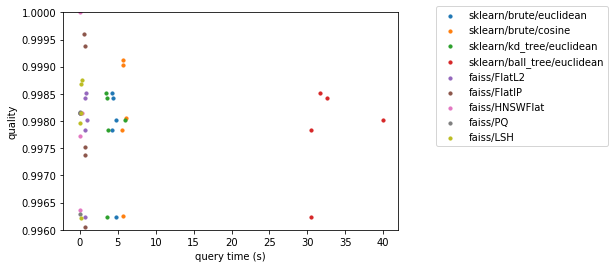

In [209]:
plt.figure()
for i in range(0, 45, 5):
    plt.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)
plt.ylim(0.996, 1)
plt.xlabel('query time (s)')
plt.ylabel('quality')
plt.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean', 'sklearn/ball_tree/euclidean', 
            'faiss/FlatL2', 'faiss/FlatIP', 'faiss/HNSWFlat', 'faiss/PQ', 'faiss/LSH'], bbox_to_anchor=(1.1, 1.05))
plt.show()

<Figure size 432x288 with 0 Axes>

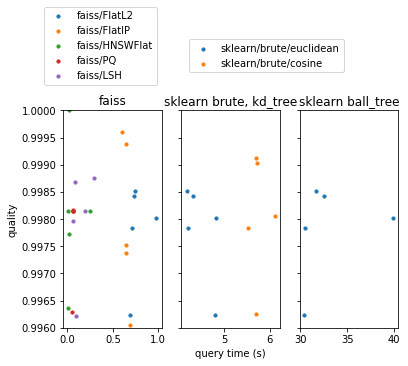

In [212]:
plt.figure()

f,(ax, ax2, ax3) = plt.subplots(1,3,sharey=True, facecolor='w')

for i in range(0, 10, 5):
    ax2.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)

ax3.scatter(a[15:20]['query time (s)'], a[15:20]['quality'], s=10)

for i in range(20, 45, 5):
    ax.scatter(a[i:i+5]['query time (s)'], a[i:i+5]['quality'], s=10)

plt.ylim(0.996, 1)

ax.set_title('faiss')
ax2.set_title('sklearn brute, kd_tree')
ax3.set_title('sklearn ball_tree')
ax2.set_xlabel('query time (s)')
ax.set_ylabel('quality')


ax.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/HNSWFlat', 'faiss/PQ', 'faiss/LSH'], bbox_to_anchor=(1, 1.5))
ax2.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean'], bbox_to_anchor=(1.7, 1.35))

plt.show()

In [ ]:
#Conclusion: sklearn algorithms maintain a strong level of success but are slower to query than faiss

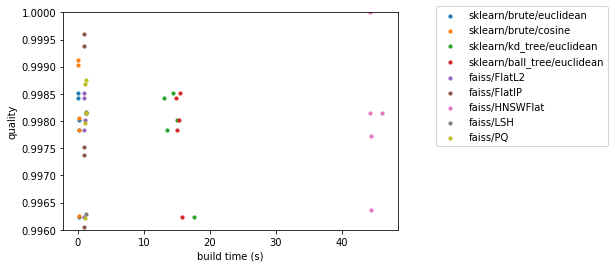

In [213]:
plt.figure()
for i in range(0, 45, 5):  
    plt.scatter(a[i:i+5]['build time (s)'], a[i:i+5]['quality'], s=10)

plt.ylim(0.996, 1)
plt.xlabel('build time (s)')
plt.ylabel('quality')
plt.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine', 'sklearn/kd_tree/euclidean', 
            'sklearn/ball_tree/euclidean', 'faiss/FlatL2', 'faiss/FlatIP', 
            'faiss/HNSWFlat', 'faiss/LSH', 'faiss/PQ'], bbox_to_anchor=(1.1, 1.05))
plt.show()

<Figure size 432x288 with 0 Axes>

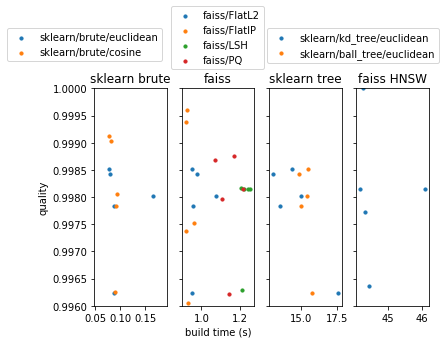

In [208]:
plt.figure()

f,(ax, ax2, ax3, ax4) = plt.subplots(1,4,sharey=True, facecolor='w')


ax.scatter(a[:5]['build time (s)'], a[:5]['quality'], s=10)
ax.scatter(a[5:10]['build time (s)'], a[5:10]['quality'], s=10)
ax3.scatter(a[10:15]['build time (s)'], a[10:15]['quality'], s=10)
ax3.scatter(a[15:20]['build time (s)'], a[15:20]['quality'], s=10)
ax2.scatter(a[20:25]['build time (s)'], a[20:25]['quality'], s=10)
ax2.scatter(a[25:30]['build time (s)'], a[25:30]['quality'], s=10)
ax4.scatter(a[30:35]['build time (s)'], a[30:35]['quality'], s=10)
ax2.scatter(a[35:40]['build time (s)'], a[35:40]['quality'], s=10)
ax2.scatter(a[40:45]['build time (s)'], a[40:45]['quality'], s=10)
plt.ylim(0.996, 1)

ax.set_title('sklearn brute')
ax2.set_title('faiss')
ax3.set_title('sklearn tree')
ax4.set_title('faiss HNSW')
ax2.set_xlabel('build time (s)')
ax.set_ylabel('quality')

ax.legend(['sklearn/brute/euclidean', 'sklearn/brute/cosine'], bbox_to_anchor=(1, 1.3))
ax2.legend(['faiss/FlatL2', 'faiss/FlatIP', 'faiss/LSH', 'faiss/PQ'], bbox_to_anchor=(1.2, 1.4))
ax3.legend(['sklearn/kd_tree/euclidean', 'sklearn/ball_tree/euclidean'], bbox_to_anchor=(2.4, 1.3))

plt.show()

In [ ]:
#Build time is often inconsequential, as a model is often built once and then queried many times